<div>
    <img src="https://www.cee.cornell.edu/sites/default/files/styles/width_700/public/content/page/header-image/blur-close-up-ripple-355700.jpg" alt="Water" width=100% style="opacity:0.7">
    <h1 style="font-size: 60px; color:black; position:absolute; transform: translate(2%,-290%); text-align:center; font-family: 'Times New Roman', serif"><b>Water Resources Engineering Assignment</b></h1>
    <p style="font-size: 20px; color:black; position:absolute; transform: translate(42%,-290%); text-align:center; font-family: 'Times New Roman', serif">Mageline Duquesne, Marie Domingues Dos Santos, Romain Phan</p>    
</div> 
<br>
<div style="font-family: 'Times New Roman', serif">
    <p style="text-align: center;font-size:16px">January 3<sup>rd</sup>, 2022 <br> <br>
        <i><u>Note:</u> all our functions are on the file "Git4.py"</i> </p>
</div>

<h2 style="color:red">TO-DO list :</h2>
<ul>
    <li>Revoir Q11 : le graphe n'est pas celui demandé</li>
    <li>Q12 & Q13</li>
    13 Ok non --> revoir le graphe (faire que vert = orange - rouge)
    <li>vérifier les noms des variables en anglais</li>
    <li>Q15 unités</li>
    <li>Relire fautes ? (routine --> routing)</li>
    <li>Si volume d'eau > volume max, vérifier que tout se passe bien</li>
    <li>Q18 blabla</li>
</ul>

In [21]:
import math
%run Git4.py

#Plot nice graphs
import seaborn as sns
sns.set_theme(style="whitegrid")

<h2 style="color:red">Calibration </h2>    

**1. Report the best fit parameters for the hydrological model.**

We ran our algorithm *opt_param()* with a maximum of 25,000 iterations. This lead to slightly less than 4,000 accepted iterations but the algorithm was unable to reach the set objective of a NS indicator greater than 0.87. Instead, it reached approximately 0.8636, which is still a good fit. Below are the exact values of the NS indicator and the associated parameters found by the algorithm.

In [11]:
NS_best = 0.8635821259811005

K_sat_best =   8.917139784983246e-07 # [m/s]
c_best =       8.596762122339547     # [-]
t_sub_best = 112.66087163624084       # [h] 
z_best =     345.4618694910228       # [mm]

For improved accuracy, we decided to run the algorithm a second time with only 20,000 iterations, since the best parameters in the previous run were found before the iteration 10,000. This lead to a slightly lower NS value (the difference being $7\cdot10^{-6}$), and the parameters are also very close to each other.

In [18]:
NS_2 = 0.8635750303310568

K_sat_2 =   9.111428972397207e-07 # [m/s]
c_2 =       8.342962234370434     # [-]
t_sub_2 = 108.9762134644488       # [h] 
z_2 =     353.1269734122299       # [mm]

####

print("Relative difference between the optimal parameters and the second best ones for:")
print("\nNS \tK_sat \tc \tt_sub \tz")
print(str(rel_diff(NS_2, NS_best, 3))+"%\t" +\
     str(rel_diff(K_sat_2, K_sat_best, 2))+"%\t" +
     str(rel_diff(c_2, c_best, 2)) + "%\t" +\
     str(rel_diff(t_sub_2, t_sub_best, 2))+"%\t" +
     str(rel_diff(z_2, z_best, 2))+"%")

Relative difference between the optimal parameters and the second best ones for:

NS 	K_sat 	c 	t_sub 	z
-0.001%	2.18%	-2.95%	-3.27%	2.22%


As one can easily see, the parameters found differ at most 3% from each other. This is strong evidence in favor of our parameters. They are certainly not the best ones available in the whole domain, but they are quite close to these best ones. 

**4. Plot Markov chains of the calibrated parameters and sequences of values of N S and TSA as a function of the number of iterations. Only plot accepted parameter sets.** 


<i><u>Note:</u> Due to the long calculation time (>15h), the plots here are images and not actual plots from the noteboook.</i>

![NS Indicator plot](img/ns.jpg)

![Markov chain of the parameters 1/2 plot](img/markov1.jpg)
![Markov chain of the parameters 2/2 plot](img/markov2.jpg)

**Comments:** We note a gradual convergence of the NS indicator towards 0.87, although it does not actually reach the defined threshould of 0.87. The convergence of $K_{sat}$ occurs quite early compared to the others (accepted iteration number = 3000). The values of $c$ and $t_{sub}$ seem to fluctuate a lot, they may have a smaller impact on the model than the other ones. Regarding the $z$ parameter, we note a strong correlation between the peak between 1000 and 1500 and the sudden decrease of the NS indicator. This might suggest that high values of $z$ have a strong effect on the NS indicator and the validity of the model with the given parameters. In addition, the value of $z$ converges very early towards its final value.

<h2 style="color:red">Hydrological variables </h2>

**2. Plot the time series (6-year-long) of precipitation [mm/h], run off [mm/h], infiltration [mm/h], soil moisture, leakage [mm/h] and evapotranspiration [mm/h] for the calibrated hydrological model forced by the given precipitation).**

Computing the hydrological model's response to our best fit parameters and the given precipitation( we use the hydr_model function that is in the Git4 file):

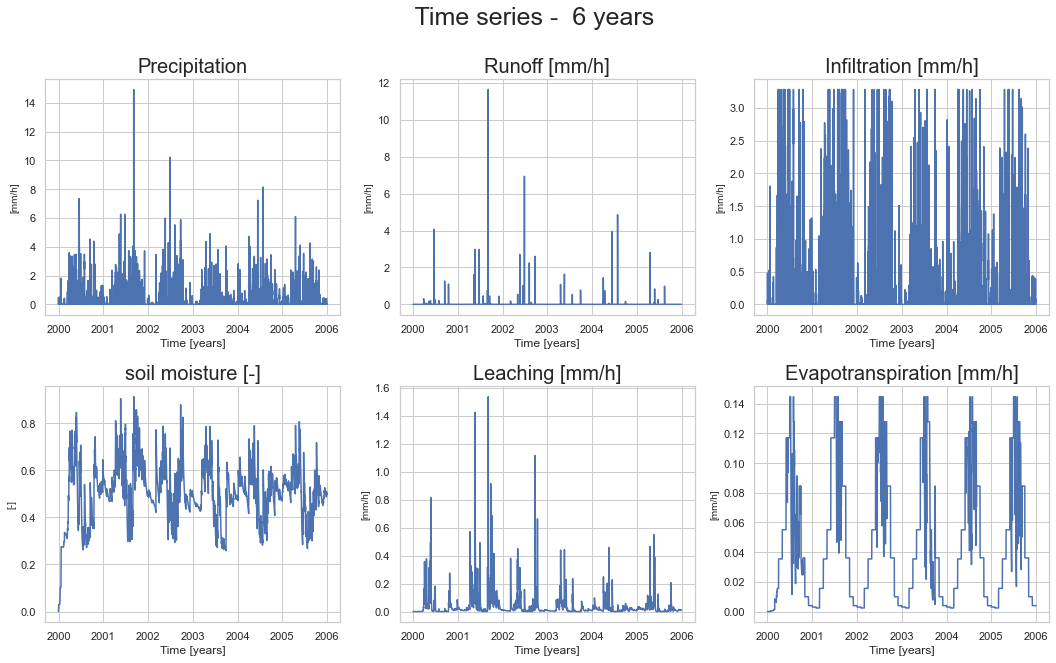

In [4]:
[Q, R, I, s, L, ET] = hydr_model(K_sat_best, c_best, t_sub_best, z_best, \
                                 precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

plot_model(precipitation, R, I, s, L, ET, True) 
# set last parameter to True to plot precipitation, False to plot discharge. Changes display units & titles only

**Comments :** We observe that the simulated **runoff** and **leaching** present the same peaks as the observed precipitations plotted above, which is coherent. For the **infiltration** and the **soil moisture**, it is more difficult to identify peaks. Again, this behaviour is expected since infiltration is more reactive to high precipitation events, which occur rather randomly. The soil moisture is also somehow random since it depends on the precipitation, but it seems to follow a pattern throughout each year. We can also note that the beginning value of the soil moisture is not coherent and should be put at around 0.5 (which seems to be the average of the soil moisture). This boundary condition only affects the first few months of the first year. The relative impact of this parameter thus depends on the duration of the simulation : a one-year simulation will be strongly affected by this parameter whereas a 100-year simulation will give the same output regardless of this parameter. In addition, we observe that **evapotranspiration** is quite periodic. Actually, the envelope of this curve is periodic, but the fluctuations inside the envelope are more random, for they are determined by the soil moisture. 

<h2 style="color:red">Discharge</h2>

__3. Plot the time series of observed discharge and of the discharge as simulated by the
        hydrological model with the best fit parameters.__

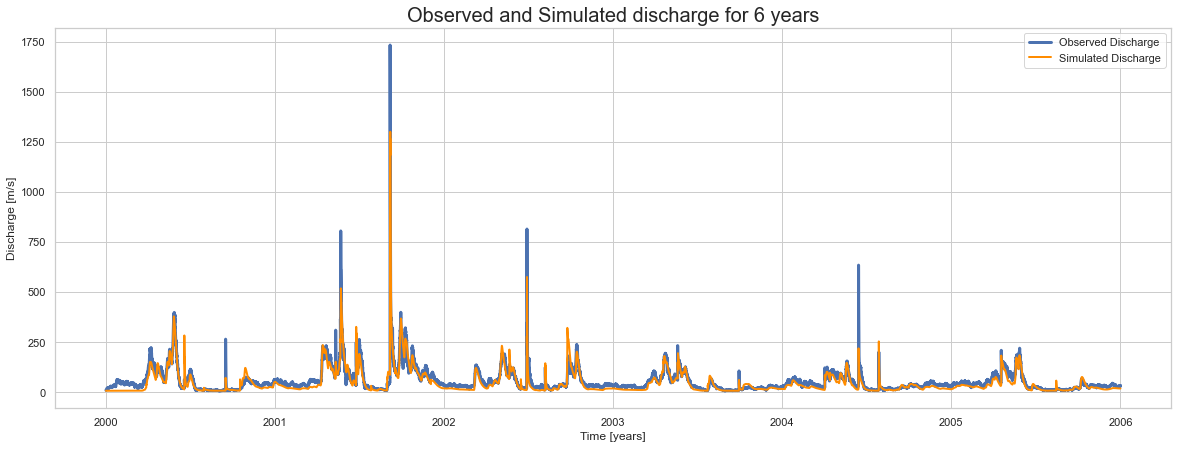

In [6]:
figure=plt.figure(figsize=(20,7))
t = [2000 + i/365/24 for i in range((len(Q)))]
plt.plot(t, Q_obs,label="Observed Discharge", linewidth=3 )
plt.plot(t, Q, label="Simulated Discharge",color="darkorange", linewidth=2)
plt.xlabel("Time [years]")
plt.ylabel("Discharge [m/s]")
plt.title("Observed and Simulated discharge for 6 years",fontsize=20)
plt.legend()
plt.show()

**Comments:** We observe that the simulated and observed discharges are quite similar : the two curves overlap well throughout the six years. However, we can note two defects in the discharge simulation. \
First, the observed discharge peaks are higher than the simulated ones. This means that our model is not suited for extreme precipitation events, such as the one that occured in the last half of 2001. Our model still shows a peak, but the uncertainty associated to it is quite high. \
Second, this model seems to smooth out the discharge. For example, in the end of 2000 and at the beginning of 2001 the original curve has many fluctuations that are unseen in our modelling curve. \

All in all, this model is quite accurate to describe monthly or weekly averages but fails to account for more rapid fluctuations. It also underestimates discharge values during intense precipitation events.

<h2 style="color:red"> Generation of precipitation </h2>

**5. Plot the comparison between the statistics (mean, standard deviation, α and λ) of
the observed and generated precipitation**

In [7]:
day_month=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # number of days for each month
month_end=np.cumsum(day_month)-1                           # last day of each month
month_start=month_end-day_month+1                          # first day of each month

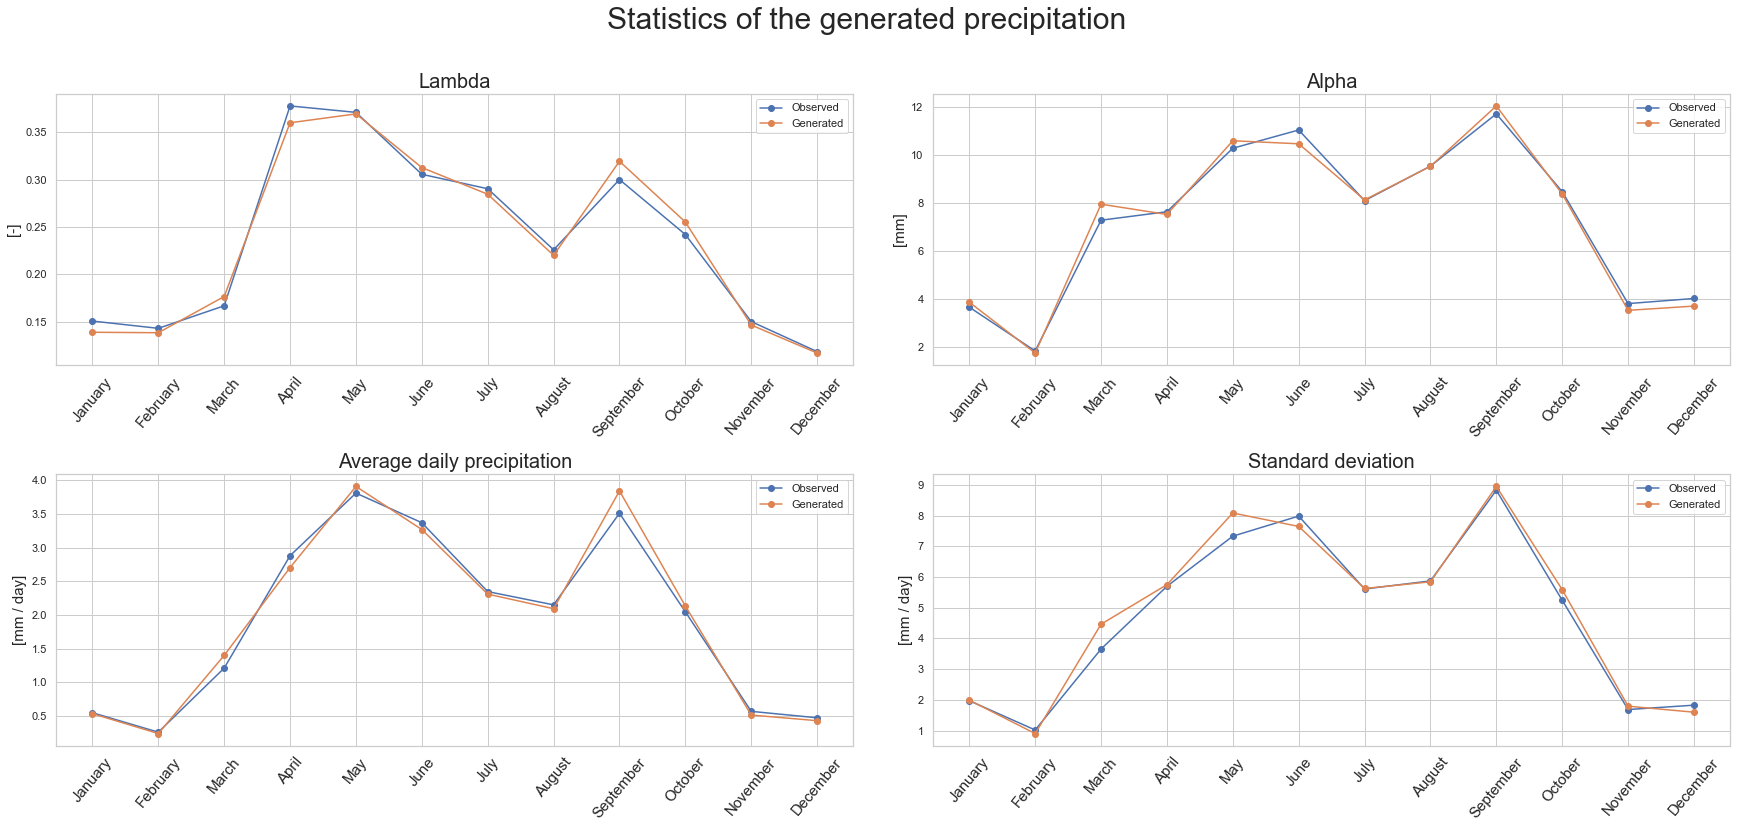

In [24]:
P=rain_gen(years=100,plot=True)

**Comments:** We observe an excellent overlapping of the 4 different parameters for each month. However, this does not mean that the generated and observed precipitations are exactly the same. For instance, extreme events will not be generated at the same time nor with the same intensity. 

<h2 style="color:red"> Simulation of hydrological variables </h2>

**6. Plot the time series (100-year-long) of generated precipitation in [mm/h], run off in
[mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in [mm/h] for the calibrated hydrological model forced by the generated
precipitation)**

In [9]:
# simulation of the hydrological model for 100 years
[Q, R, I, s, L, ET] = hydr_model(K_sat_best, c_best, t_sub_best, z_best, \
                               P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

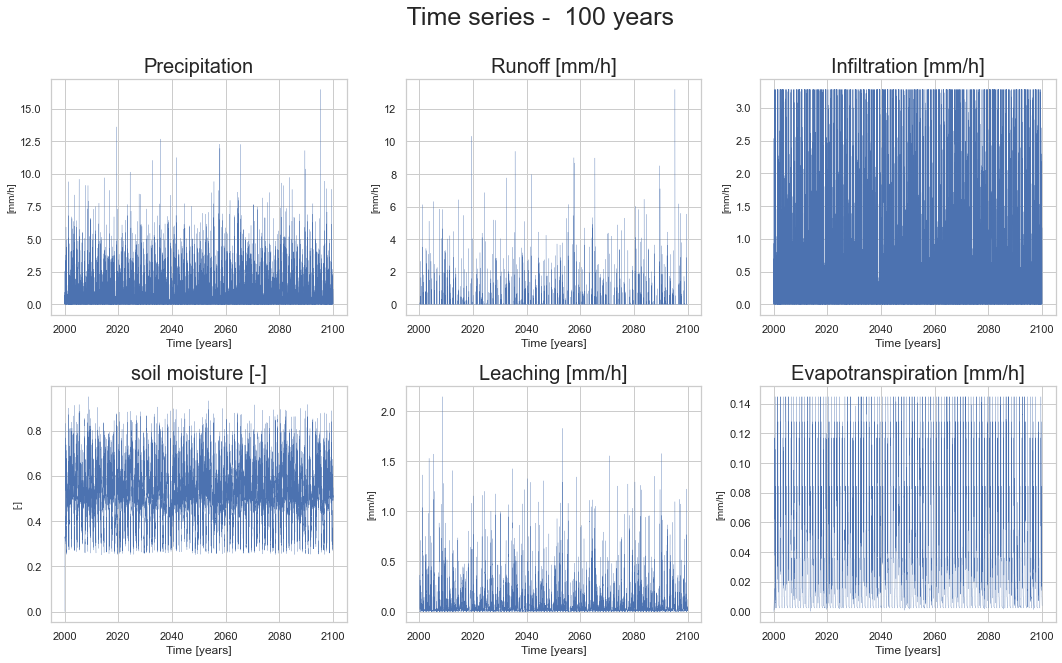

In [10]:
# plotting the results
plot_model(P, R, I, s, L, ET, True, linewidth=0.2) # True = replace Q by P in plots, for display purposes only

**Comments:** Due to the 100-year simulation, it is hard to see the behaviour of the curve. We can however still note that the orders of magnitude of these quantities stay similar to those shown in question 2.

<h2 style="color:red"> Reservoir Area and Volume Rating curves </h2>

**7. Plot the area and the volume rating curves for the given levels.**

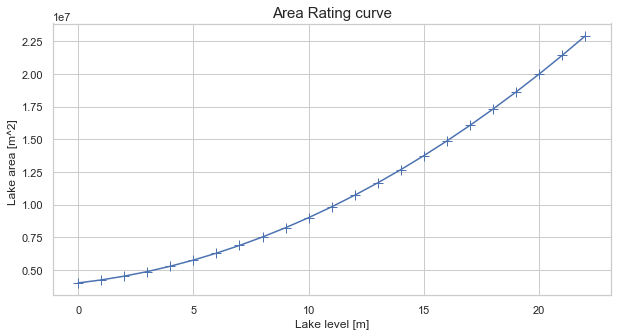

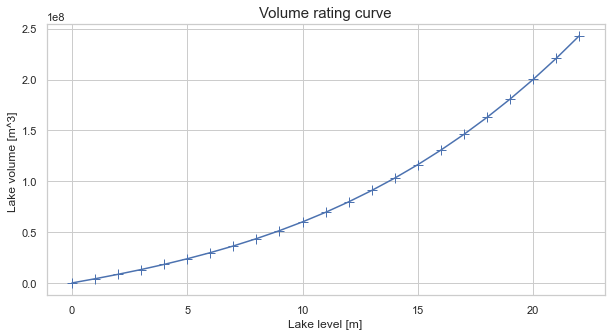

In [26]:
# AREA RATING CURVE
elevation=[k for k in range(23)]
figure=plt.figure(figsize=(10,5))
plt.plot(elevation,A_rating, marker="+", markersize=10)
plt.xlabel("Lake level [m]")
plt.ylabel("Lake area [m^2] ")
plt.title("Area Rating curve",fontsize=15)
plt.show()

# VOLUME RATING CURVE
V_rating = vol_rat_curve(A_rating)
figure=plt.figure(figsize=(10,5))
plt.plot(elevation,V_rating, marker="+", markersize=10)
plt.xlabel("Lake level [m]")
plt.ylabel("Lake volume [m^3] ")
plt.title("Volume rating curve",fontsize=15)
plt.show()

The algorithm *vol_rat_curve* computes the volume rating curve according to the following procedure:
<ul>
    <li>For the elevation 0, the volume is set to 0</li>
    <li>For each other elevation, the additional volume gained by rising the level of one meter (from height $i$ to height $i+1$) is equal to $\frac{1}{2}\times(A_i + A_{i+1})$, where $A_i$ and $A_{i+1}$ are the area values of the lake at height $i$ and $i+1$.</li>
    <li>For each other non-integer elevation, the algorithms interpolates linearly between the two surrounding points.</li>
</ul>

<h2 style="color:red"> Discharge and reservoir routing </h2>

**8. Report the minimum flow (discharge that is equalled or exceeded 95% of the time)
of the generated discharge and plot the discharge duration curves**

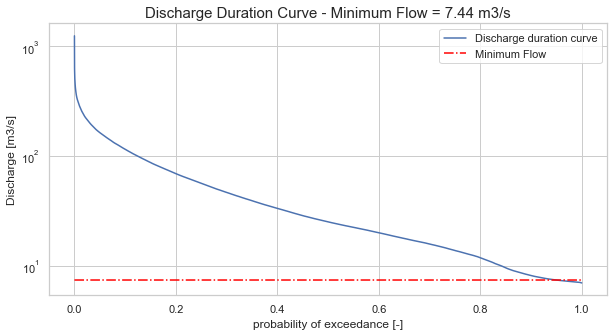

Q347 = 7.436019704491729 [m3/s]


In [13]:
print("Q347 = " +str(Q_347(Q, plot=True))+" [m3/s]") # m3/s

**9. For a maximum level for hydroelectric use of 15 m, plot the time series (100 years
long) of input discharge, output discharge, volume within the reservoir and level**

In [27]:
# computation of the model
[Q, R, I, s, L, ET]=hydr_model(K_sat_best, c_best, t_sub_best, z_best, \
                               P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

# routing of the reservoir
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages,n_year] = reservoir_routine(Q,P,ET,V_rating,lmax_HU=15)

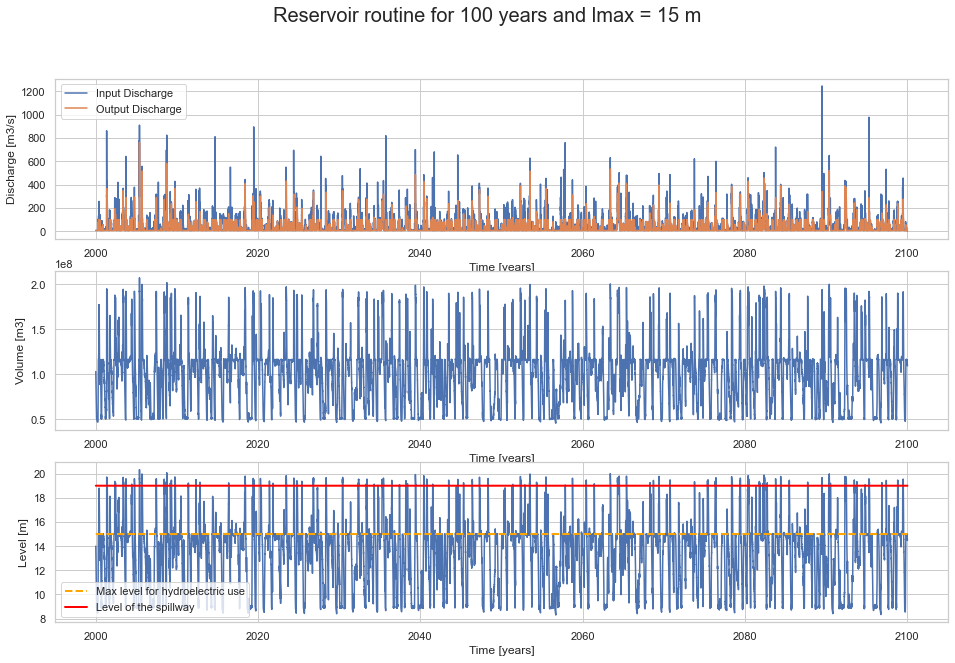

In [15]:
plot_routine(Q,Q_out,V,l,15)

**Comments :** Over 100 years, we observe many episods where the level is above the maximum level for hydropower production. There are even fewer periods when the water level is actually higher than the spillway: this only hapens in case of extreme rainfall events, which happen quite regularly.

# Check kl why 2.5?
# c'est quoi kl = 2.5 ?c'est le coefficient de frottement turbines, j'ai l'impression que l'année dernière c'était 1.5
# mdr j'adore discuter avec toi comme ça. bref à la ligne 950 j'ai enlevé le 2.5, je sais pas d'où il sort

**10. Plot the average annual energy production in [GWh] and the probability that Qout
exceeds Qlim for different values of the maximum level for hydroelectrical use.**

In [19]:
print("The Annual Energy Production is = "+ str(E_annual) + " GWh")

NameError: name 'E_annual' is not defined

<p><b>Comments:</b> This corresponds well to the order of magnitude of the annual production of a hydropower plant. The <a href="https://www.bfe.admin.ch/bfe/en/home/supply/renewable-energy/hydropower.html">Swiss Federal Office of Energy</a> indicates that "<i>677 hydropower plants [...] produce an average of around 36,741 gigawatt hours (GWh/a) per annum</i>". Our dam produces almost twice as much electricity as the average Swiss hydropower plant. However, the 677 power plants account for run-of-river dams as well as storage dams. Our simplified model can also explain the discrepancy between our production value and the one obtained in Switzerland.</p>

In [28]:
lmax=np.linspace(9,19,21)
energy=[]
money=[]
prob_flood=[]
revenue=[]
damages=[]
for element in lmax:
    [V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages,n_years] = \
        reservoir_routine(Q,P,ET,V_rating,lmax_HU=element)
    energy.append(E_annual)
    money.append(profit)
    damages.append(Damages*1000000)
    prob_flood.append(p_flood)
    revenue.append(profit+ Damages*1000000)
    
max_money=money[0]
best_l=lmax[0]
for i in range (1,len(lmax)):
    if money[i]>max_money:
                max_money=money[i]
                best_l=lmax[i]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Average annual energy production')

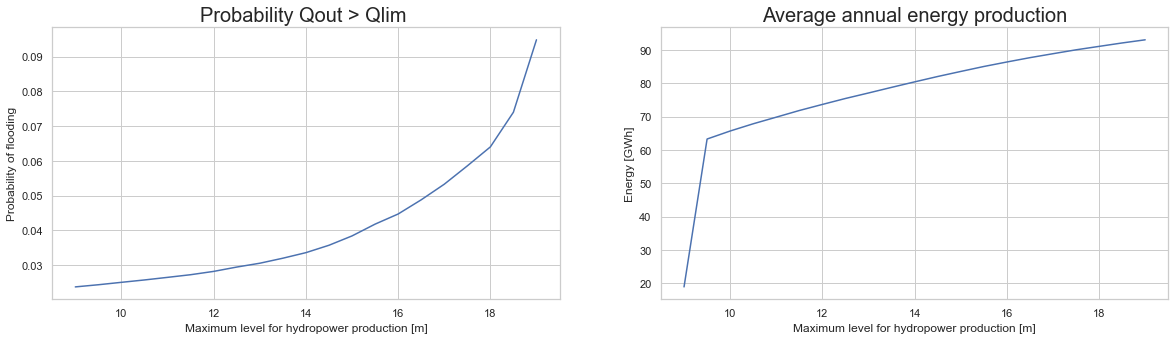

In [17]:
#plt.plot(lmax,money)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lmax,prob_flood)
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Probability of flooding")
ax.set_title("Probability Qout > Qlim ",fontsize=20)

plt.subplot(1,2,2)
plt.plot(lmax,energy)
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Energy [GWh]")
ax.set_title("Average annual energy production",fontsize=20)
plt.show()

**14. Report the value of the maximum level for hydroelectric production that maximizes
the income function**

The best level for hydropower production is  16.0 m


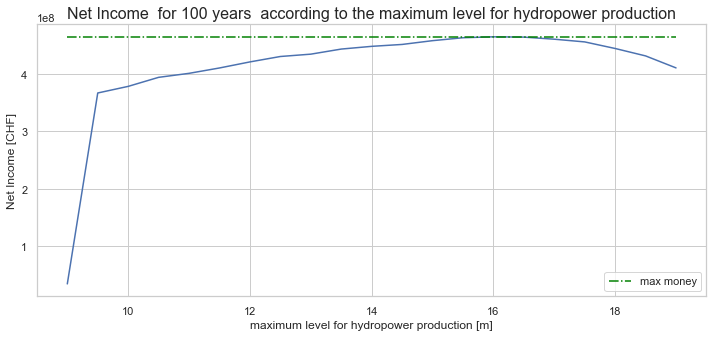

In [18]:
figure=plt.figure(figsize=(12,5))
plt.plot(lmax,money)
plt.plot(lmax,[max_money]*len(lmax),linestyle="-.", color="green",label="max money")
plt.xlabel("maximum level for hydropower production [m]")
plt.ylabel("Net Income [CHF]")
plt.title("Net Income for "+str(int(n_year))+" years according to the maximum level for hydropower production",fontsize=16)
plt.legend()

print("The best level for hydropower production is  " + str(best_l) +" m")

**Comments:** We get approximately 450 million CHF for a maximum level of hydroproduction equal to 16 meters.

##  <p style="color:red">  Multi-Criteria optimization </p>

**11. Plot the Pareto front of average annual energy production in [GWh] vs the probability that Qout exceeds Qlim computed from different values of the maximum level for hydroelectrical use.**

<h1 style="text-align:center; color:#00AA00">TO DO : c'est pas le bon pareto graphe</h1>

Text(0.5, 1.0, 'Pareto Front')

<Figure size 1440x504 with 0 Axes>

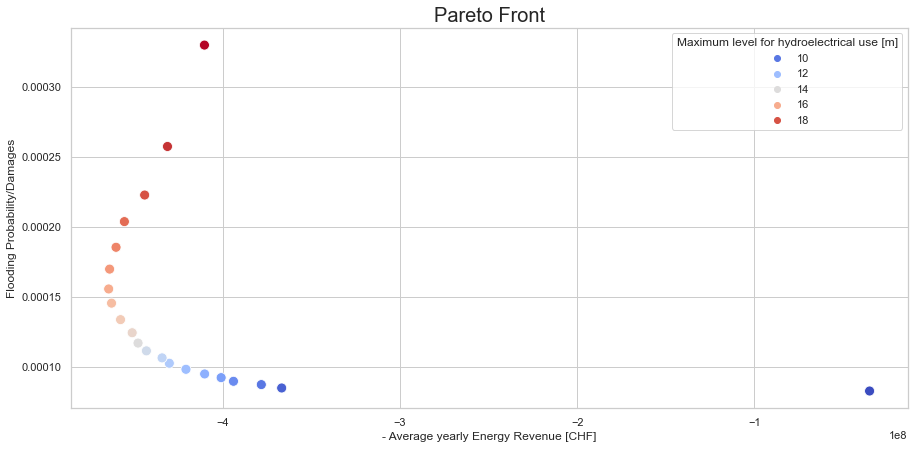

In [19]:
figure=plt.figure(figsize=(20,7))
money_r = np.array(money)    
money_n = -money_r
prob_flood_d = prob_flood/Damages
df= pd.DataFrame(lmax,columns =["Maximum level for hydroelectrical use [m]"])
#plt.plot(money_n,prob_flood_d,linestyle = 'none', marker='o', color ='red')
figure=plt.figure(figsize=(15,7))
sns.scatterplot(data=df,x=money_n,y=prob_flood_d,hue="Maximum level for hydroelectrical use [m]",palette="coolwarm",s=100)
plt.xlabel('- Average yearly Energy Revenue [CHF]')
plt.ylabel('Flooding Probability/Damages')
plt.title("Pareto Front",fontsize=20)
plt.show()

**12. Elaborate on why this graph could be useful when choosing one value of maximum
level for hydroelectrical use over the other.**

<h1 style="text-align:center; color:#00AA00"> TO DO, avec le bon graphe</h1>

**13. Plot the revenue, expenditure, and income functions for each value of the maximum
level for hydroelectric production. The template for this picture is not provided**

Text(0, 0.5, 'Money (CHF)')

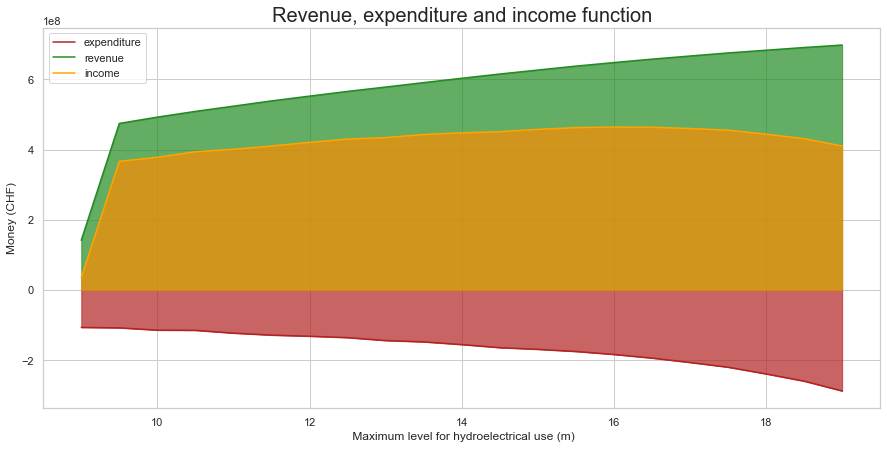

In [56]:
# data from United Nations World Population Prospects (Revision 2019)
# https://population.un.org/wpp/, license: CC BY 3.0 IGO
year = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2018]

figure=plt.figure(figsize=(15,7))
plt.plot(lmax,ex,label="expenditure",color="firebrick")
plt.plot(lmax,revenue,label="revenue",color="forestgreen")
plt.plot(lmax,money,label="income",color="orange")

plt.fill_between(lmax, ex,  color="firebrick",alpha=0.7)
plt.fill_between(lmax, revenue,  color="forestgreen",alpha=0.7)
plt.fill_between(lmax, money,  color="darkorange",alpha=0.7)
plt.legend()
plt.title('Revenue, expenditure and income function',size=20)
plt.xlabel(' Maximum level for hydroelectrical use (m)')
plt.ylabel('Money (CHF)')
plt.show()

<h1 style="text-align:center; color:#00AA00">Revoir le graphe pour qu'il corresponde aux valeurs</h1>

<h2 style="color:red">  Climate change </h2>

In [29]:
#plt.plot(month_name,T_m,label="Current")
#plt.plot(month_name,T_future,label="Future simulation")
#plt.xticks(rotation=45)
#plt.title("Monthly Temperature")
#plt.legend()
#plt.show()

# pas besoin de ça ^

**15. Plot the comparison of the monthly statistics of rainfall and the mean monthly discharge in [m3/s] computed under the current conditions and climate change conditions.**

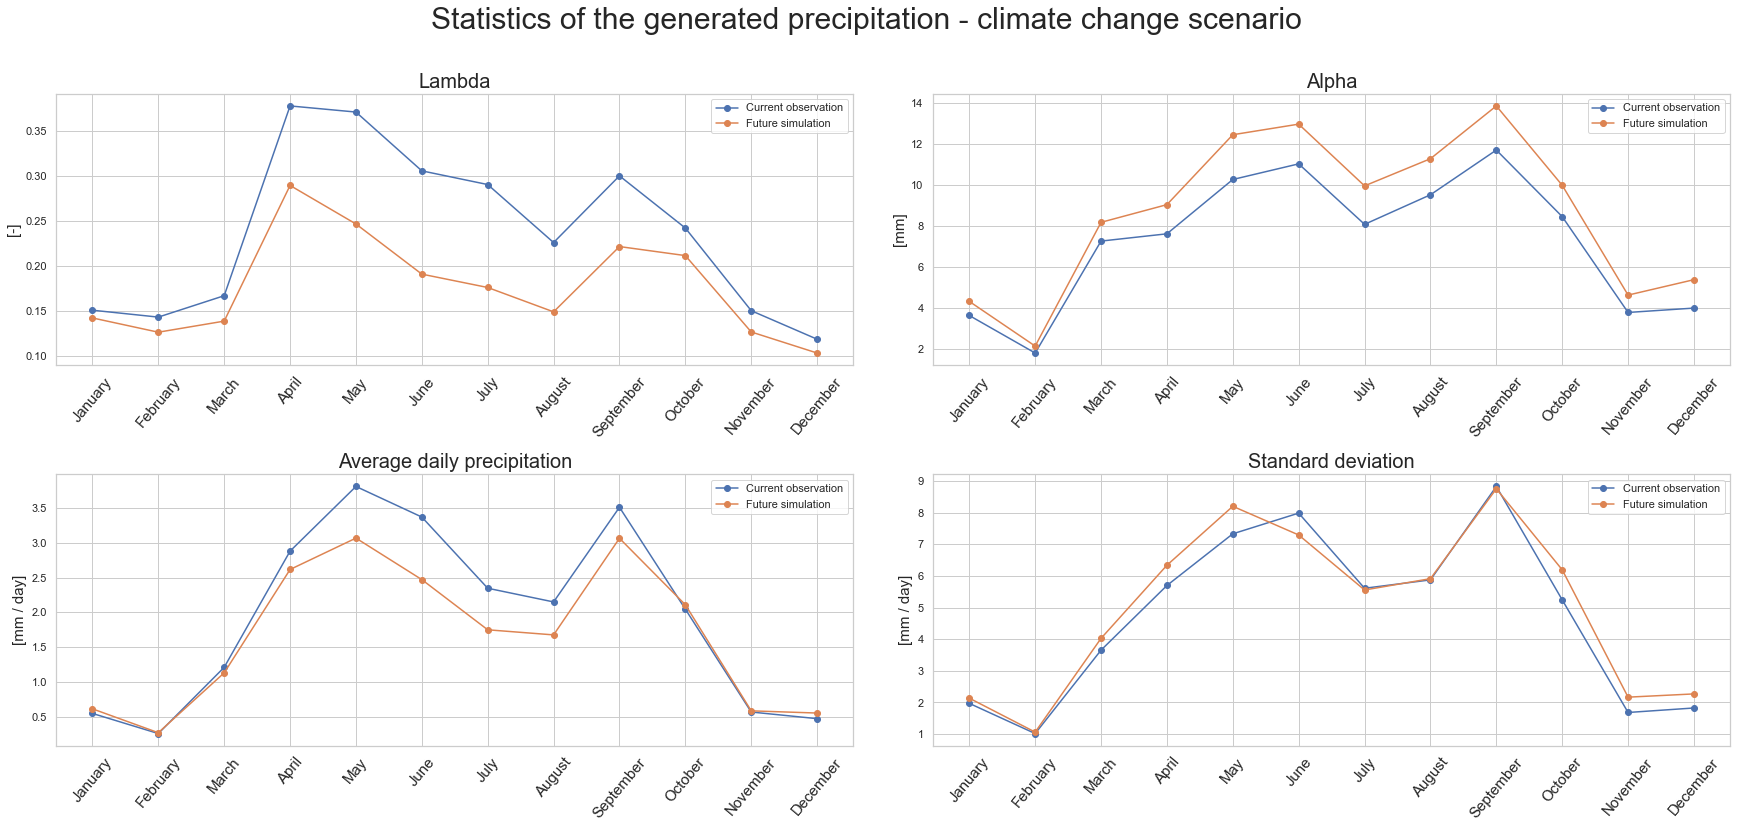

In [21]:
precipitation_change=rain_gen(years=100,plot=True,climate_change=True,alpha_c=alpha_c)

**Comments :** We observe that the monthly precipitation is lower in a climate change scenario, especially for months between April and September. The monthly standard deviation is slightly higher in the climate change scenario. Precipitation is less frequent but has an stronger intensity. It can have different consequences on the hydrological system, namely on precipitation, evaporation and evapotranspiration. This type of result is what one would expect with the influence of climate change.

In [83]:
# Climate change variables
[Q_f, R_f, I_f, s_f, L_f, ET_f]=hydr_model(K_sat, c, t_sub, z, precipitation_change, K_c, \
                                           n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0, T=T_future)
# Present variables for comparison
#[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

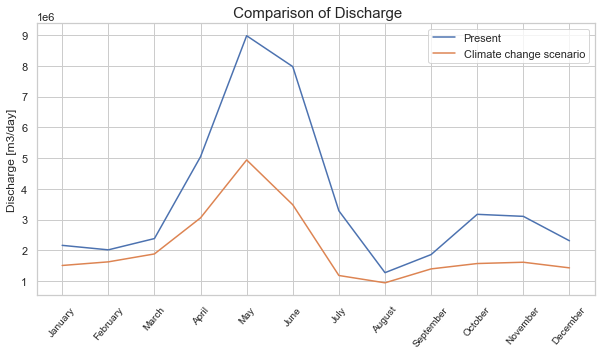

In [84]:
mQ=np.asarray(monthly_mean(Q))*3600
mQf=np.asarray(monthly_mean(Q_f))*3600
plt.figure(figsize=(10,5))
plt.plot(month_name,mQ,label="Present")
plt.plot(month_name,mQf,label="Climate change scenario")
plt.xticks(rotation=50,fontsize=10)
plt.ylabel("Discharge [m3/day]")
plt.title(" Comparison of Discharge",fontsize=15)
plt.legend()
plt.show()

**Comments:** We observe a strong reduction of the discharge for every month. The gap is especially high in June and October. This might reduce significantly the energy production in the power plant, while at the same time lowering the number of floods !

# Check Units 

**16. Plot the comparison between the energy production and flooding probability under
current and climate change conditions.**

In [87]:
#[V_f,l_f,A_sluice_f,Q_out_f,Q_HU_f,Q_g_f,Pow,profit_f,p_flood_f,E_annual_f,Damages_f,n_year]=reservoir_routine(Q_f,precipitation_change,ET_f,V_rating,lmax_HU=13.5)

WARNING: This part takes a lot of time to run

In [89]:
lmax=np.linspace(9,19,21)
energy_f=[]
money_f=[]
prob_flood_f=[]
for element in lmax:
    [V_f,l_f,A_sluice_f,Q_out_f,Q_HU_f,Q_g_f,Pow,profit_f,p_flood_f,E_annual_f,Damages_f,n_year]=reservoir_routine(Q_f,precipitation_change,ET_f,V_rating,lmax_HU=element)
    energy_f.append(E_annual_f)
    money_f.append(profit_f)
    prob_flood_f.append(p_flood_f)
    
max_money_f=money_f[0]
best_l_f=lmax[0]
for i in range (1,len(lmax)):
    if money_f[i]>max_money_f:
                max_money_f=money_f[i]
                best_l_f=lmax[i]

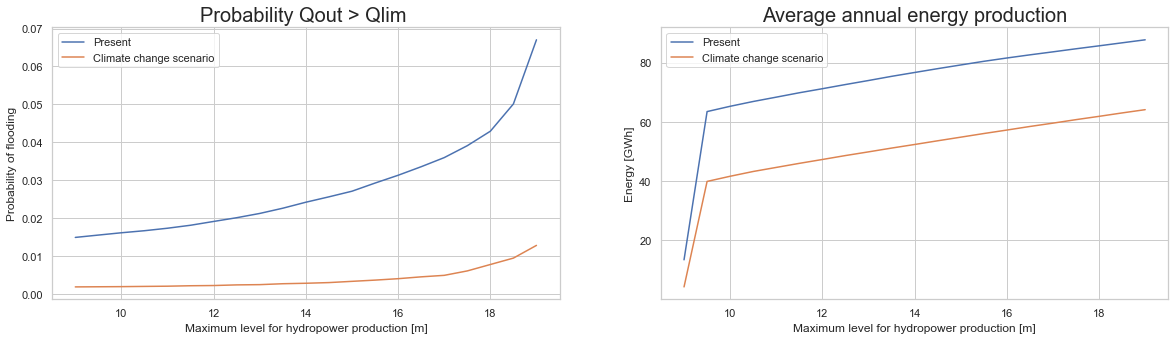

In [90]:
#plt.plot(lmax,money)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lmax,prob_flood,label="Present")
plt.plot(lmax,prob_flood_f,label="Climate change scenario")
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Probability of flooding")
ax.set_title("Probability Qout > Qlim ",fontsize=20)
plt.legend()

plt.subplot(1,2,2)
plt.plot(lmax,energy,label="Present")
plt.plot(lmax,energy_f,label="Climate change scenario")
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Energy [GWh]")
ax.set_title("Average annual energy production",fontsize=20)
plt.legend()
plt.show()

**Comments :** We observe that the probability of flooding decreases in a climate change scenario. We also observe that the average annual energy production decreases. This result is coherent with the one obtained at the question 15.

**17. Plot the comparison between the income function for different levels under current
and climate change conditions.**


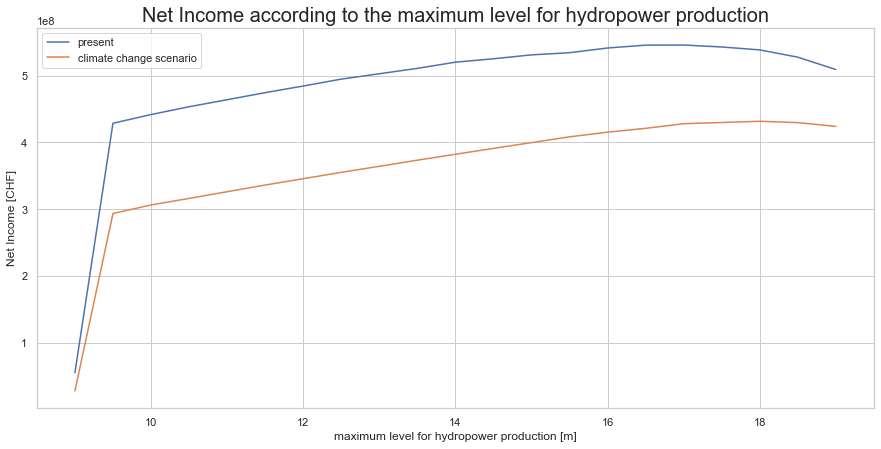

In [92]:
figure=plt.figure(figsize=(15,7))
plt.plot(lmax,money,label="present")
plt.plot(lmax,money_f,label="climate change scenario")
plt.xlabel("maximum level for hydropower production [m]")
plt.ylabel("Net Income [CHF]")
plt.title("Net Income according to the maximum level for hydropower production",fontsize=20)
plt.legend()
plt.show()

**18. Elaborate on the impact of climate change on the operation of the reservoir**